In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True
saver_step = 10

class_name = raw_input('Give me the class type: ').lower()
ae_id = raw_input('Give me the AE/experiment ID: ').lower()
cmp_type = raw_input('Comparison Type ("best" epoch vs. "max_min" epoch): ').lower()

syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = '_'.join(['nb_wgan_gp_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

Give me the class type: chair
Give me the AE/experiment ID: 10
Comparison Type ("best" epoch vs. "max_min" epoch): best


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
ae_help = relevant_class(ae_loss)

In [7]:
# Load Auto-Encoder
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
bneck = ae.bottleneck_size
assert(ae_help.experiment_id_to_bneck[int(ae_id)] == bneck) 

if cmp_type.startswith('best'):
    load_epoch, _ = ae_help.best_epochs[bneck]
    print load_epoch
elif cmp_type.startswith('max'):
    load_epoch, _ = ae_help.max_min_epochs[bneck]
else:
    assert(False)
    saved_epochs = read_saved_epochs(ae_conf.train_dir)
    load_epoch = saved_epochs[-1]

ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

960
Model restored in epoch 960.


In [8]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [17]:
# reconstructed = ae.decode(latent_codes)
# save_dir = osp.join(top_data_dir, 'OUT/icml/ae_reconstructed_point_clouds')
# create_dir(save_dir)
# save_file = osp.join(save_dir, 'ae_' + ae_id + '_2048pts_' + ae_loss + '_' + cmp_type)
# np.savez(save_file, reconstructed)

In [ ]:
# TODO : make GAN conf.
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = ae.bottleneck_size
max_epochs = 500

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [ae.bottleneck_size]

lam = 10
beta = 0.5
disc_kwargs = {'b_norm': False}
reset_tf_graph()
gan = RawGAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,\
                latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                beta=beta, disc_kwargs=disc_kwargs)


1 (-0.25958234469095864, -0.15523817541974563)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


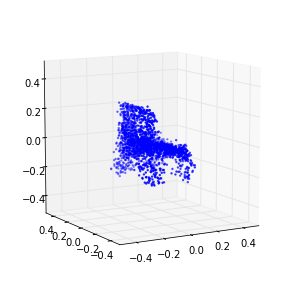

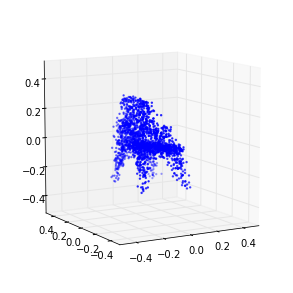

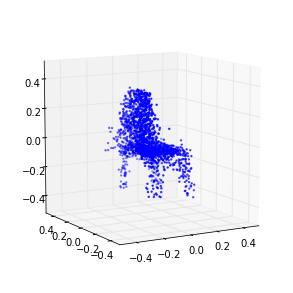

2 (-1.5904281342471087, -0.58758689849464985)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


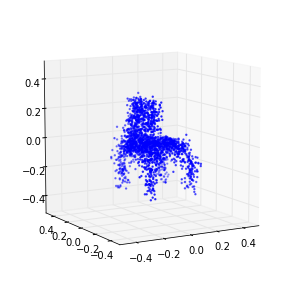

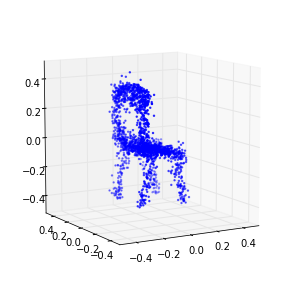

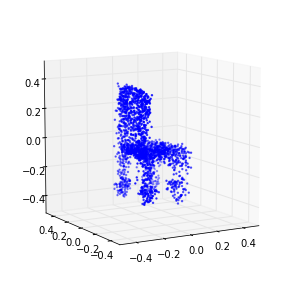

3 (-1.4970713606587163, -0.77765544034816603)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


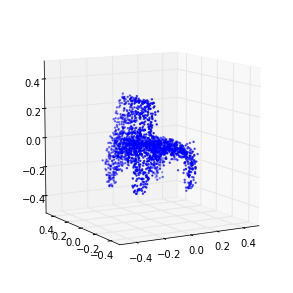

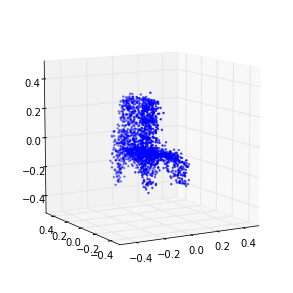

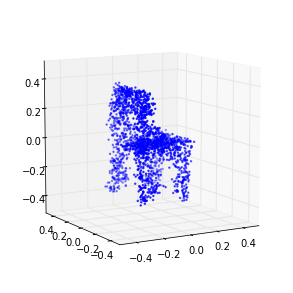

4 (-1.3616436446154558, -0.82619853814442956)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


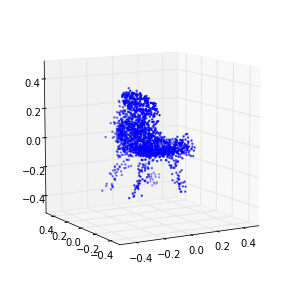

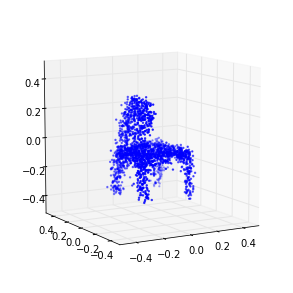

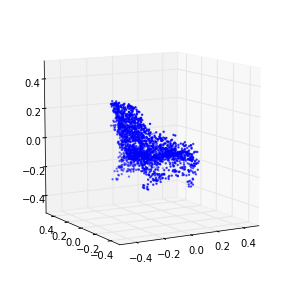

5 (-1.2045209279766789, -0.82498375795505663)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


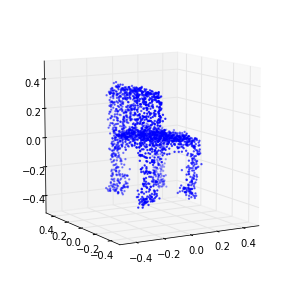

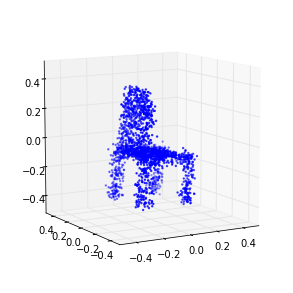

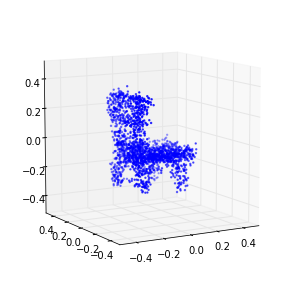

6 (-1.0359537270334032, -0.84369228062806301)
7 (-0.87100227055726231, -0.82580046300534848)
8 (-0.72837028017750494, -0.69919336062890514)
9 (-0.63973487615585323, -0.43229978945520187)
10 (-0.61037649931731053, -0.19274792075157166)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


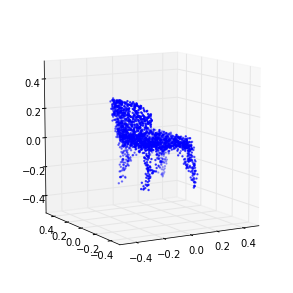

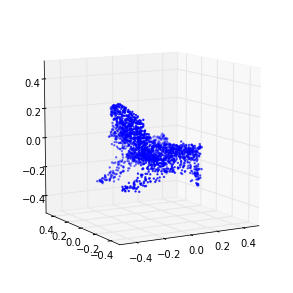

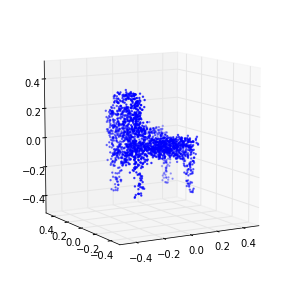

11 (-0.5866941423327835, -0.10215209041618639)
12 (-0.5572749186445165, -0.1331362057891157)
13 (-0.52168975053010158, -0.1947353137312112)
14 (-0.49382686173474349, -0.20548122900503654)
15 (-0.44892483750979106, -0.20315488110537883)
16 (-0.41048077013757495, -0.26376689694545885)
17 (-0.37585282149138272, -0.26764172536355479)
18 (-0.33261859074786859, -0.30195053418477374)
19 (-0.30726921392811668, -0.33367166199066023)
20 (-0.26569238095371811, -0.33641052797988608)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


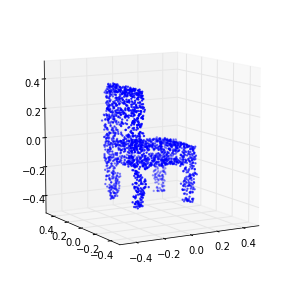

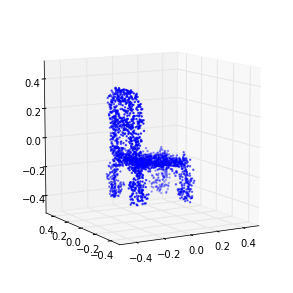

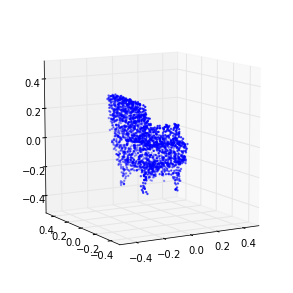

21 (-0.23837799827257791, -0.33455097785702459)
22 (-0.20982719634970029, -0.3876066936386956)
23 (-0.19041530589262645, -0.25161257303423351)
24 (-0.17404071509286209, -0.31133134773483984)
25 (-0.15848396707464146, -0.25151198185738866)
26 (-0.14677631361065088, -0.2034016858993305)
27 (-0.14195425209623797, -0.18339974488373156)
28 (-0.15049340128898619, -0.20600010185605949)
29 (-0.1454285724847405, -0.053232050224862715)
30 (-0.15144168740069425, -0.19072583183232281)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


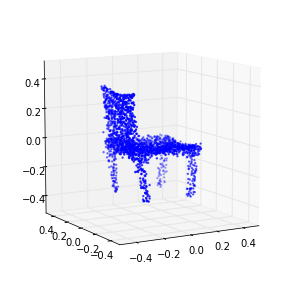

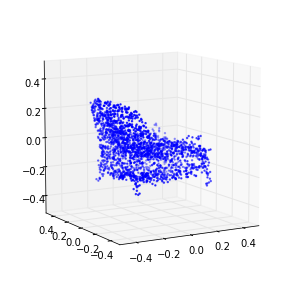

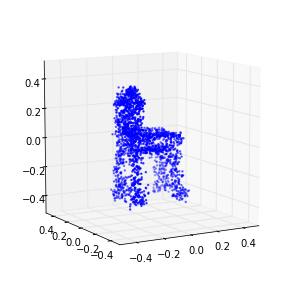

31 (-0.15675025157354497, -0.010251412306118894)
32 (-0.16781889862484403, -0.2930863380984024)
33 (-0.16910718006116374, -0.065402711025887614)
34 (-0.1799137720907176, -0.14610591748108467)
35 (-0.1822619753855246, -0.10872296799250224)
36 (-0.1918332658984043, -0.13754327098528543)
37 (-0.1947786447626573, -0.12098438154768061)
38 (-0.19555725068957716, -0.20669715092689903)
39 (-0.19437768624888527, -0.12928920860091844)
40 (-0.19943676309453118, -0.10642010770324203)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


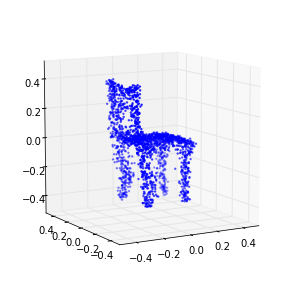

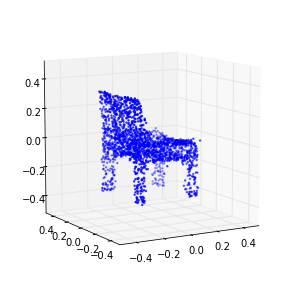

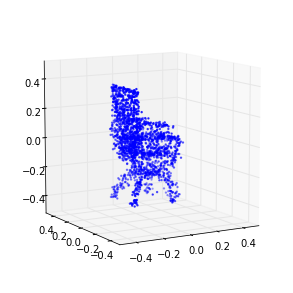

41 (-0.20353469302256902, -0.14526272537531676)
42 (-0.20189259063314507, -0.15423020651495015)
43 (-0.2036540397339397, -0.10053053108492384)
44 (-0.20205470472574233, -0.11214102508017311)
45 (-0.20322891368910118, -0.046930033144437604)
46 (-0.20812690473265119, -0.076372490747383351)
47 (-0.20635028244168671, -0.059991747951479976)
48 (-0.20744272525663729, -0.071426988165411681)
49 (-0.20665188547637728, 0.0028322605864593278)
50 (-0.20640497886472278, -0.055856297827429242)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


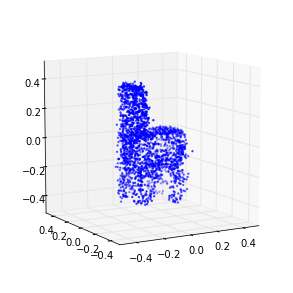

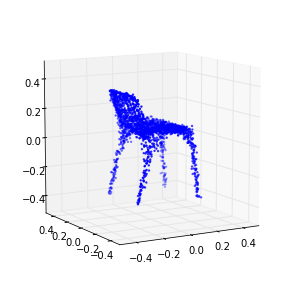

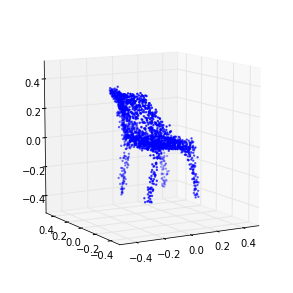

51 (-0.2078970855584851, 0.0119719622415249)
52 (-0.20681823928047111, -0.006338503418697251)
53 (-0.20796433179466814, 0.051902331325604963)
54 (-0.20718069087575983, 0.02336246996290154)
55 (-0.20396671720125056, 0.072459090846004312)
56 (-0.20616798494701033, 0.090157843677809948)
57 (-0.20609084947241676, 0.1152541325600059)
58 (-0.2106124856405788, 0.070055594874752894)
59 (-0.1999192738422641, 0.099500013756807199)
60 (-0.20853278907360853, 0.12600186480968087)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


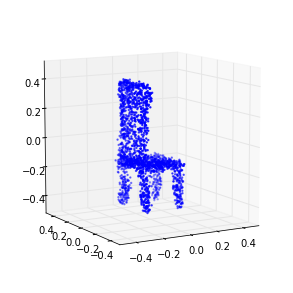

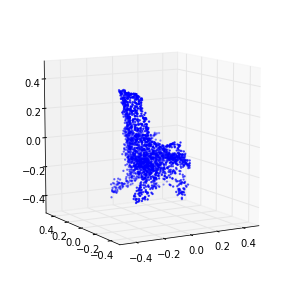

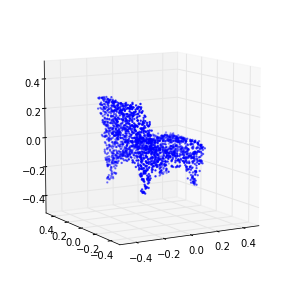

61 (-0.20378358049525155, 0.09852936829405802)
62 (-0.20768209486095993, 0.12537608571626521)
63 (-0.20644440286689333, 0.13488769924475086)
64 (-0.205509468195615, 0.16890044068848645)
65 (-0.2091459670552501, 0.16447561648156908)
66 (-0.20603312844479527, 0.18325309896910633)
67 (-0.21255652374691433, 0.19313786316801002)
68 (-0.21119885317705295, 0.15848912574626781)
69 (-0.21026529609053224, 0.17818234088244261)
70 (-0.20999739832348294, 0.134020218004783)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


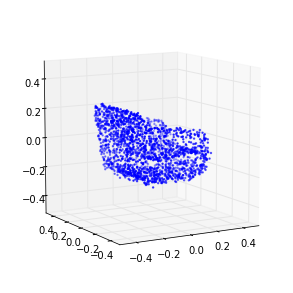

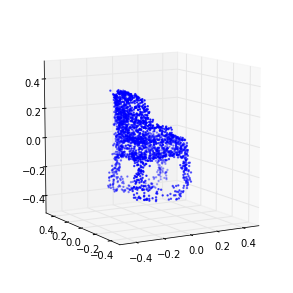

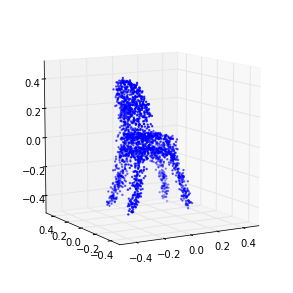

71 (-0.20635986902095654, 0.19262895319196913)
72 (-0.20556397007571325, 0.18011901334480004)
73 (-0.20761600280249559, 0.14899845966310413)
74 (-0.20620545993248621, 0.20618491978557021)
75 (-0.20333585154127193, 0.10977187042159063)
76 (-0.20335831884984618, 0.17772607753674188)
77 (-0.20523482307239815, 0.16258669561809963)
78 (-0.20153373060403046, 0.17229332112603718)
79 (-0.20972791501769314, 0.16116331255546323)
80 (-0.20311365353840369, 0.14884171438299948)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


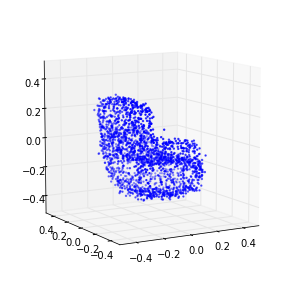

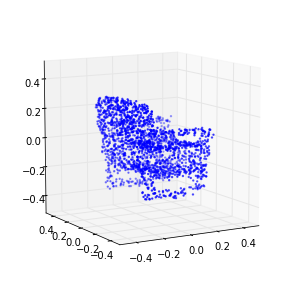

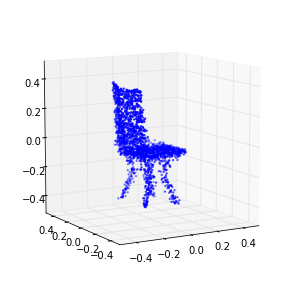

81 (-0.20554533937463054, 0.15898221400048998)
82 (-0.19929789194354305, 0.16054437682032585)
83 (-0.19984180408495444, 0.16855634748935699)
84 (-0.20395008949217974, 0.16342235798085178)
85 (-0.20292789381411341, 0.17288813519257087)
86 (-0.19967372963825861, 0.12512917538104509)
87 (-0.20075618304588178, 0.13352127587077794)
88 (-0.20198468201690251, 0.17512881507476172)
89 (-0.19912744777070152, 0.11936015266649148)
90 (-0.20292574294187404, 0.17855279754709313)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


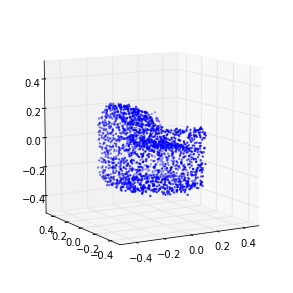

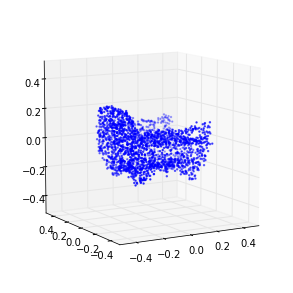

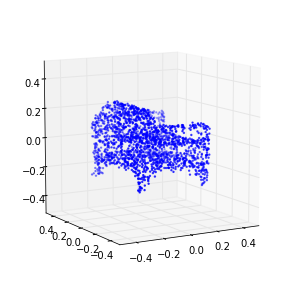

91 (-0.20057706005043455, 0.12438289821147919)
92 (-0.20118092287469794, 0.16648883427734729)
93 (-0.19630625071348967, 0.12720927209765823)
94 (-0.19633766523113957, 0.12984611680386243)
95 (-0.1994136873770643, 0.18469364692767462)
96 (-0.19804807476423406, 0.12348134981261359)
97 (-0.19600152555439207, 0.19571835851227795)
98 (-0.19647157711011393, 0.14413480226088454)
99 (-0.19417156008658587, 0.16351298932675962)
100 (-0.19522857881254621, 0.13466976569206626)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


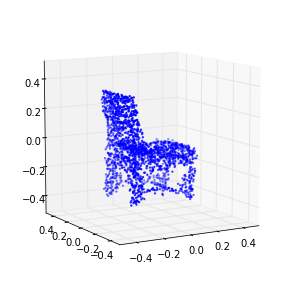

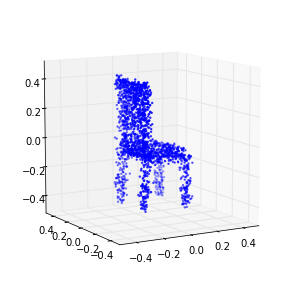

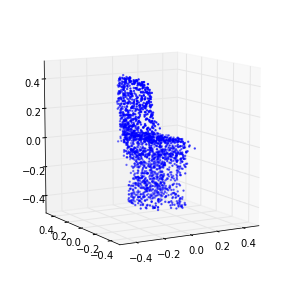

101 (-0.19889063134237572, 0.13975038517404487)
102 (-0.19922484065647478, 0.15922755872209868)
103 (-0.19539768348137537, 0.14300295131074059)
104 (-0.19600838135789941, 0.1287311082360921)
105 (-0.19546095199055141, 0.14775799801228223)
106 (-0.19058742468003873, 0.11258545131595046)
107 (-0.19459844860765668, 0.1452480446961191)
108 (-0.19329274098078411, 0.13721751173337302)
109 (-0.19196871927490941, 0.088499348541652714)
110 (-0.19139072806746871, 0.12380440712526992)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


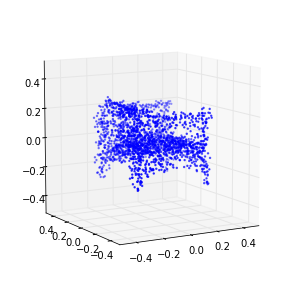

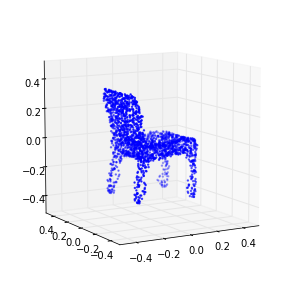

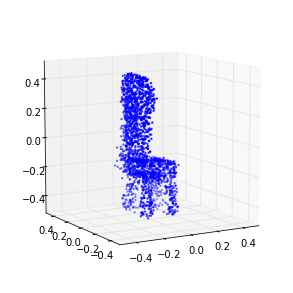

111 (-0.19077338824669521, 0.16088056840278483)
112 (-0.18868204476656736, 0.11075666112204392)
113 (-0.18941671942119245, 0.1423006162599281)
114 (-0.19376691044480712, 0.15107028227713373)
115 (-0.18763140544847207, 0.14011087599727842)
116 (-0.19150607188542684, 0.14356029585555749)
117 (-0.18601543710187629, 0.11241607133437086)
118 (-0.18512141158183415, 0.15482206670222459)
119 (-0.18704282834574029, 0.13479071689976585)
120 (-0.18658270703421698, 0.13332420394376474)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


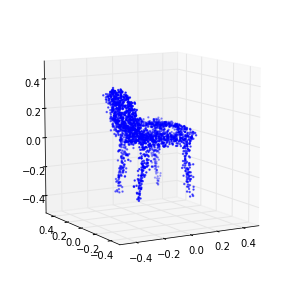

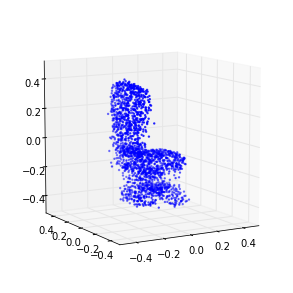

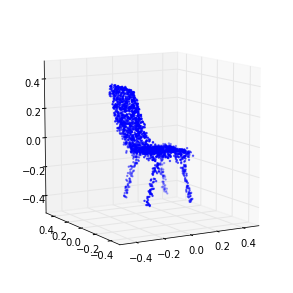

121 (-0.18676465297186817, 0.14050680040209382)
122 (-0.18640846378273435, 0.15755586464096)
123 (-0.18924312310086355, 0.14259818085917719)
124 (-0.19090766448665547, 0.12875520879471744)
125 (-0.18156050062841839, 0.13924164297404112)
126 (-0.18611337503901235, 0.13904179453297896)
127 (-0.18063141477328759, 0.14779742558797201)
128 (-0.18667005739278264, 0.12333436255101804)
129 (-0.18481160446449563, 0.14171846252348688)
130 (-0.18814146386252509, 0.11506724923297211)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


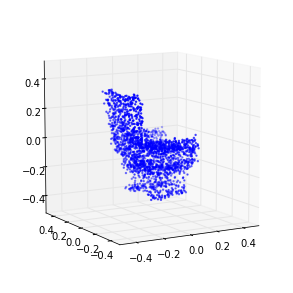

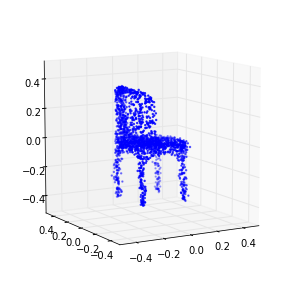

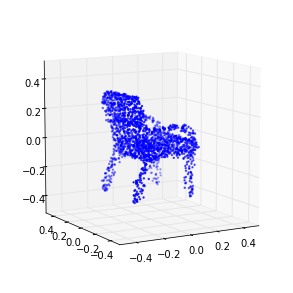

131 (-0.18211674044529597, 0.16192345031433636)
132 (-0.18445543586104005, 0.14053183462884691)
133 (-0.18514156015934768, 0.13564208177504716)
134 (-0.17967707785191359, 0.140940529052858)
135 (-0.18015234453810586, 0.12940384833901017)
136 (-0.18525824475067634, 0.13292977379428017)
137 (-0.17915517213167967, 0.14593826179151181)
138 (-0.17748794263159787, 0.12324756715032789)
139 (-0.17726127348012394, 0.14829919928753818)
140 (-0.17865568338720886, 0.11013090927843694)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


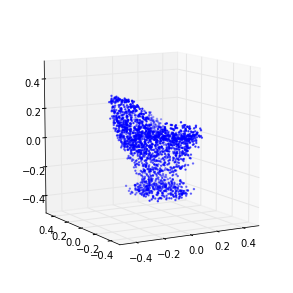

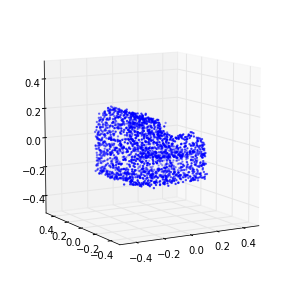

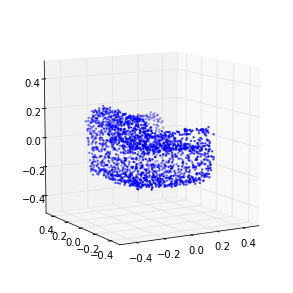

141 (-0.1768230007202537, 0.13378961881001791)
142 (-0.17713566775675174, 0.1357782939793887)
143 (-0.18037369896968206, 0.14555081504362602)
144 (-0.17758717244421995, 0.13489461579808482)
145 (-0.17608049815451657, 0.10731510445475578)
146 (-0.17496862168665286, 0.15899702409903207)
147 (-0.17613529789227025, 0.14374213555344828)
148 (-0.17870389935043124, 0.13524824767201035)
149 (-0.17964111373380379, 0.14736779613627327)
150 (-0.17348288937851233, 0.14300385503857224)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


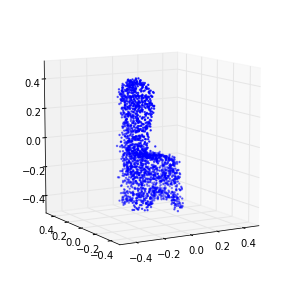

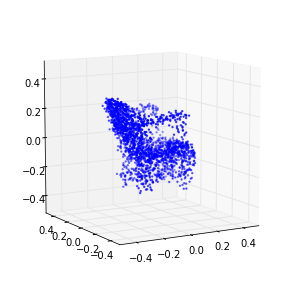

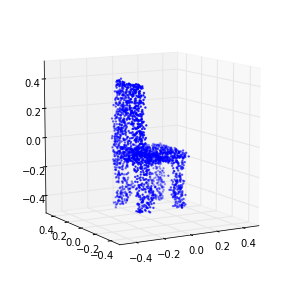

151 (-0.17329169798780369, 0.1586998231984951)
152 (-0.1780444257789188, 0.14363930098436498)
153 (-0.17441733948610447, 0.13829508796334267)
154 (-0.17286686312269281, 0.1717240211588365)
155 (-0.17588596045970917, 0.14715116195104741)
156 (-0.17290988906666085, 0.18420109097604398)
157 (-0.17281169907914268, 0.17414751207387005)
158 (-0.17516963404637795, 0.13904353810681236)
159 (-0.17096380442380904, 0.15771826494623115)
160 (-0.17711973482811894, 0.17105655344548049)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


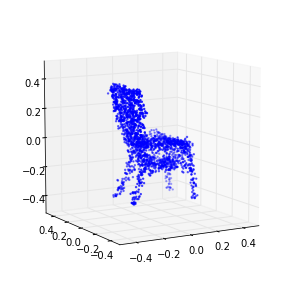

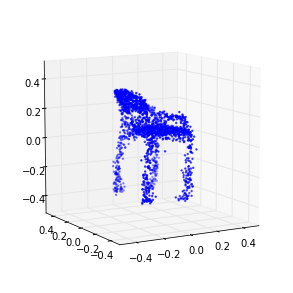

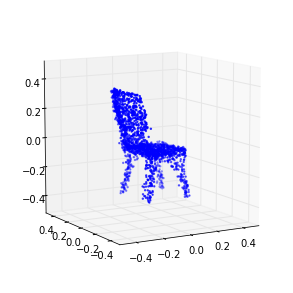

161 (-0.17566186553902097, 0.18564660350481668)
162 (-0.17219437250384578, 0.17021423026367469)
163 (-0.1683031286906313, 0.18448591177110318)
164 (-0.17481663823127747, 0.16321795164710945)
165 (-0.17687038746145037, 0.15411371861894926)
166 (-0.17325166916405713, 0.15736233084290116)
167 (-0.17110391369572392, 0.15557617045663022)
168 (-0.17296143524624683, 0.1715958195704001)
169 (-0.17674244305601827, 0.18247930346815674)
170 (-0.16836276529011904, 0.12561962049868372)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


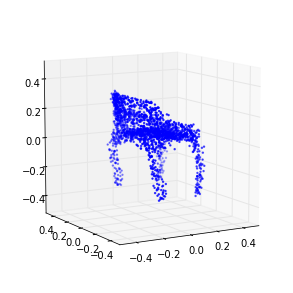

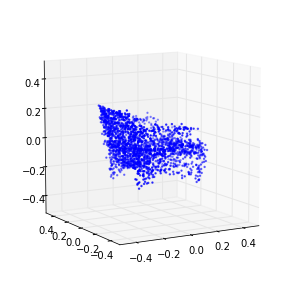

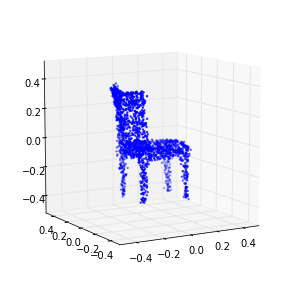

171 (-0.17055778806960142, 0.18448358525832495)
172 (-0.17435082980880032, 0.1665158768494924)
173 (-0.16977505661823131, 0.18157006910553686)
174 (-0.17138835693951007, 0.15005310017753531)
175 (-0.17028701244680969, 0.1962840410846251)
176 (-0.16768445571263632, 0.16398217942979601)
177 (-0.1753418857852618, 0.17566233542230394)
178 (-0.17059405942757924, 0.14721174400161813)
179 (-0.17115196718109979, 0.16627307539736783)
180 (-0.1700596923629443, 0.15237772216399512)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


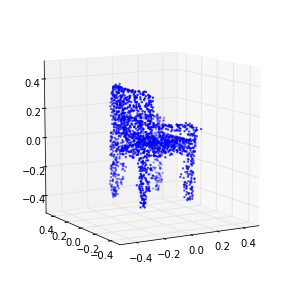

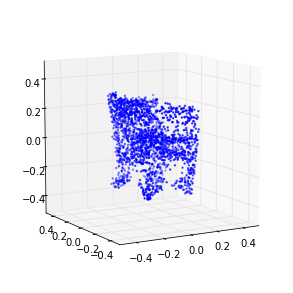

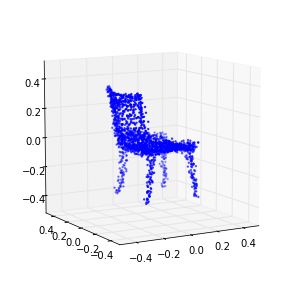

181 (-0.16692501687341266, 0.17173466665877235)
182 (-0.16941983754988069, 0.18230105770958793)
183 (-0.17035217914316389, 0.18151238781434517)
184 (-0.169383411054258, 0.17566615674230787)
185 (-0.17059176023359651, 0.20419639321389021)
186 (-0.16873208030506417, 0.18829310161096077)
187 (-0.17088104784488678, 0.16881369495833362)
188 (-0.17327273123794132, 0.16054689194317218)
189 (-0.17177503340774111, 0.16273156111990963)
190 (-0.17265578872627682, 0.15930112230556984)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


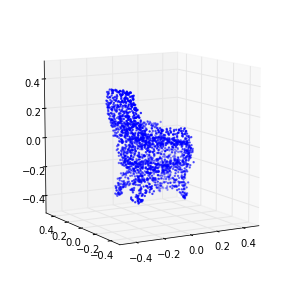

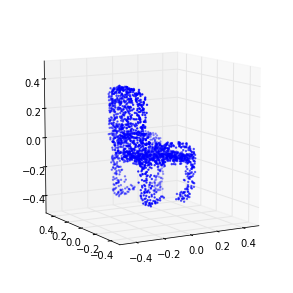

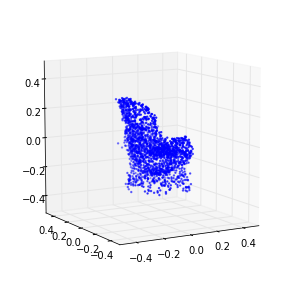

191 (-0.16764007177617815, 0.17849540710449219)
192 (-0.16987566335333718, 0.15500687476661471)
193 (-0.16833385907941395, 0.18202237370941374)
194 (-0.17074646248861594, 0.16570189898764645)
195 (-0.16760424408647751, 0.17076799935764736)
196 (-0.16957904023152812, 0.15329461241209949)
197 (-0.17358484883551245, 0.15318803268450279)
198 (-0.1689903990538032, 0.17045796386621617)
199 (-0.17180264078908497, 0.15400314662191603)
200 (-0.16721053747115311, 0.15726664551982172)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


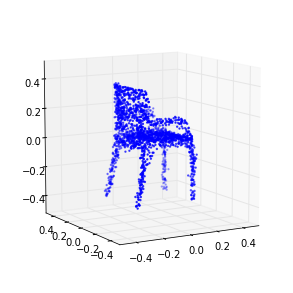

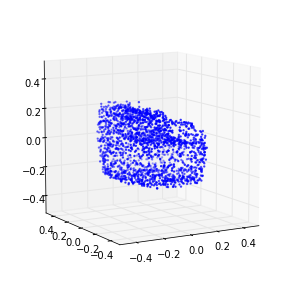

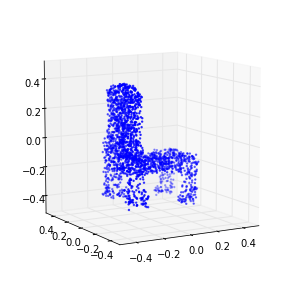

201 (-0.16779991040627162, 0.15366420370561104)
202 (-0.16820191873444451, 0.14286374990586881)
203 (-0.16735865076382955, 0.16649821704184567)
204 (-0.17254949101695308, 0.15253783569291787)
205 (-0.17162389771805869, 0.14068079325887892)
206 (-0.16764253504850246, 0.1637906719137121)
207 (-0.16598685610073585, 0.15103913898821231)
208 (-0.16782311626054622, 0.16558112093695887)
209 (-0.16888386171173167, 0.15488582959881536)
210 (-0.16877301390524263, 0.17793757026946103)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


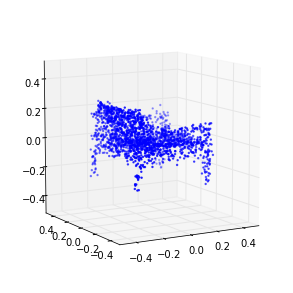

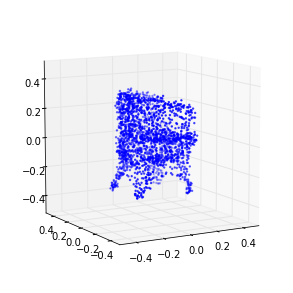

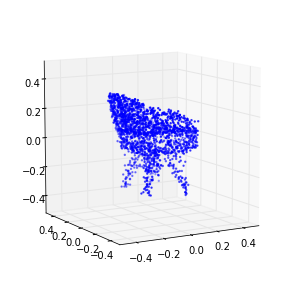

211 (-0.17411242789692349, 0.16682964066664377)
212 (-0.17083950969907974, 0.17706530955102709)
213 (-0.16798926211065715, 0.14033786814521859)
214 (-0.16881783152068103, 0.16923044897891856)
215 (-0.16758948514858882, 0.16247767706712088)
216 (-0.17129846386335515, 0.14111394766304228)
217 (-0.17250161634551153, 0.16498022305744667)
218 (-0.17145991844159586, 0.15311039680684055)
219 (-0.17129954601879474, 0.18491839507111796)
220 (-0.16891352975810014, 0.17118712652612617)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


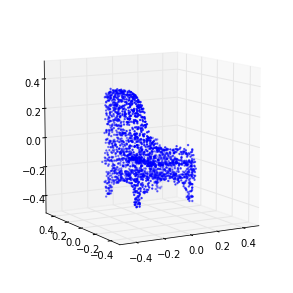

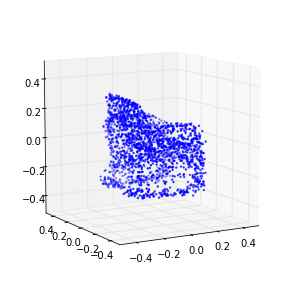

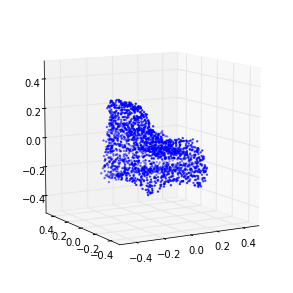

221 (-0.17027606103155349, 0.1755534863030469)
222 (-0.16795757705414738, 0.16613956458038753)
223 (-0.16918594346002297, 0.14468843821022245)
224 (-0.17063757252913933, 0.15859445791553567)
225 (-0.16647058548750701, 0.16915945405209507)
226 (-0.17348157713810602, 0.17397608414844232)
227 (-0.17242723030072671, 0.16570615216537757)
228 (-0.16840144136437663, 0.17450219558344948)
229 (-0.17108486548618035, 0.17006599351211829)
230 (-0.1679011849341569, 0.16986676498695655)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


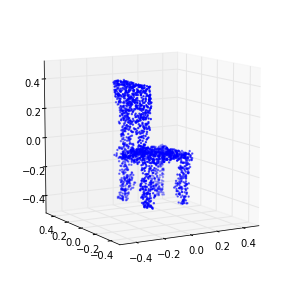

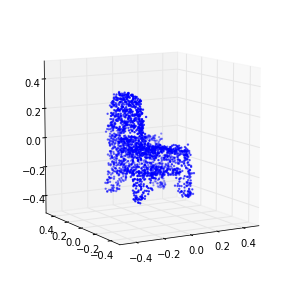

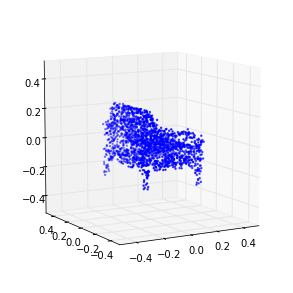

231 (-0.17367493703409478, 0.16926911832005889)
232 (-0.17030943339621579, 0.16849843881748341)
233 (-0.17109530606755505, 0.17537403106689453)
234 (-0.16506455137773796, 0.18469501314339815)
235 (-0.16941383552772027, 0.17105662767533902)
236 (-0.1679777000789289, 0.16297876393353497)
237 (-0.16702758791270078, 0.16761165967694036)
238 (-0.16879663804063091, 0.16678741519097928)
239 (-0.16873583760526445, 0.16744012233835678)
240 (-0.16579347120390997, 0.16894143571456274)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


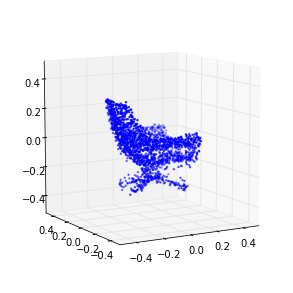

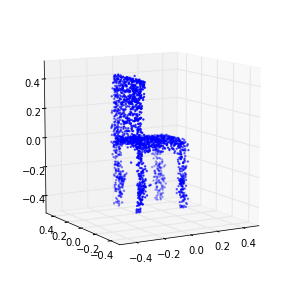

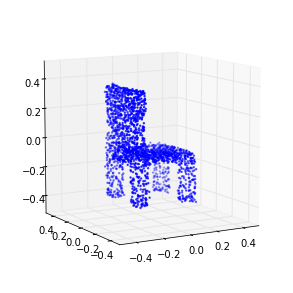

241 (-0.16974051622328934, 0.16260961250022607)
242 (-0.16768037544356451, 0.17988249549159296)
243 (-0.17013865102220466, 0.15882298653876339)
244 (-0.16828768970789731, 0.18592780883665438)
245 (-0.16596287328887868, 0.15623891408796664)
246 (-0.16893020614429757, 0.19005489846070608)
247 (-0.17173895278462656, 0.16767807884348762)
248 (-0.17039541155099869, 0.1789950974009655)
249 (-0.17324323455492655, 0.14811023821433386)
250 (-0.1682666983317446, 0.16515288529572664)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


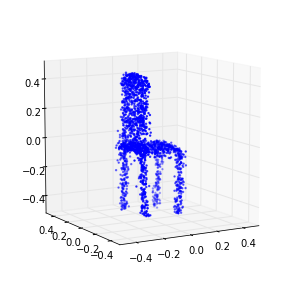

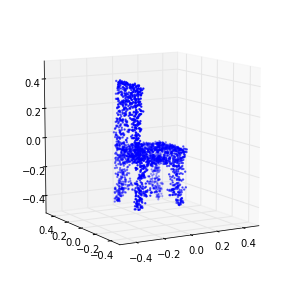

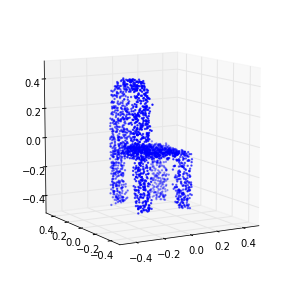

251 (-0.16886817189278425, 0.16745775938034058)
252 (-0.16819422669984677, 0.16059297212847956)
253 (-0.17382821987072627, 0.17463934145591878)
254 (-0.16595250321207222, 0.16161091239364059)
255 (-0.16878592377459561, 0.1780606883543509)
256 (-0.17036955999555412, 0.16443264953516148)
257 (-0.17338337004184723, 0.1506594306340924)
258 (-0.17345939786345871, 0.16644245551692116)
259 (-0.17101146755395114, 0.16182821492354074)
260 (-0.16778500091146539, 0.14850744605064392)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-260 is not in all_model_checkpoint_paths. Manually adding it.


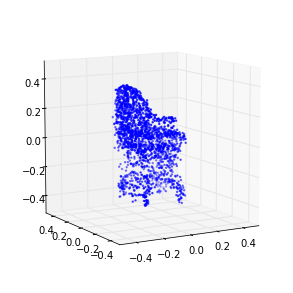

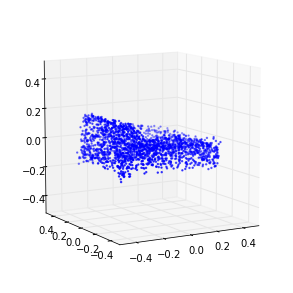

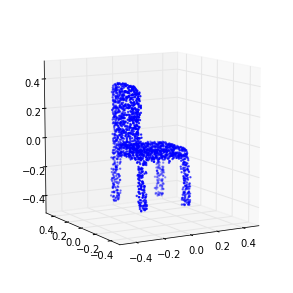

261 (-0.16652379747894075, 0.14848820782370037)
262 (-0.17196813623110455, 0.13643575735666133)
263 (-0.16996878457290154, 0.14313653139052568)
264 (-0.171737594516189, 0.1619582603927012)
265 (-0.16941286811122189, 0.16442050094957705)
266 (-0.17274131300272766, 0.17174335541548552)
267 (-0.1693680782560949, 0.13664510239053657)
268 (-0.17149033656826726, 0.15421068144065361)
269 (-0.17278455595175427, 0.13704737606975767)
270 (-0.16569137661545366, 0.15108074303026553)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.


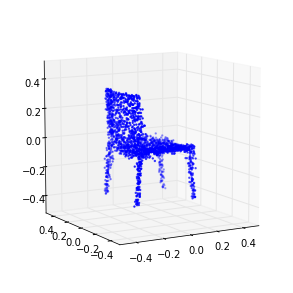

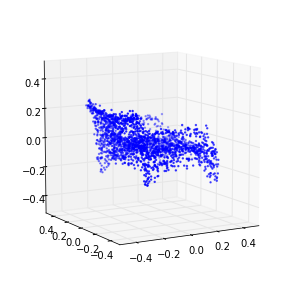

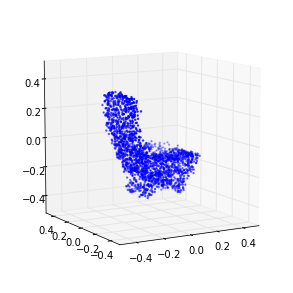

271 (-0.16894438829686906, 0.14391623658162575)
272 (-0.17189789955262785, 0.14278676084898137)
273 (-0.16992413655475333, 0.14917428901901952)
274 (-0.16936700564843638, 0.14515477922503595)
275 (-0.16578937388128703, 0.1563105583190918)
276 (-0.16757594843705495, 0.13333352682767091)
277 (-0.17163633240593804, 0.14924768744795411)
278 (-0.16762696946108782, 0.15161217638739832)
279 (-0.1747439697936729, 0.13136816383511932)
280 (-0.16585605210728116, 0.16159905714017372)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-280 is not in all_model_checkpoint_paths. Manually adding it.


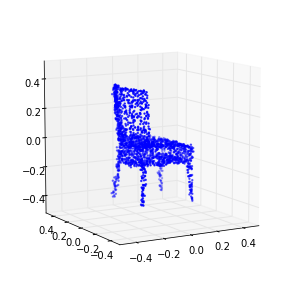

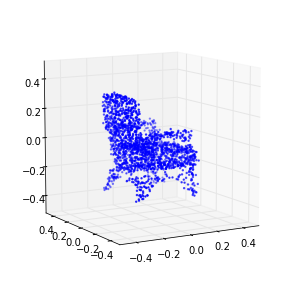

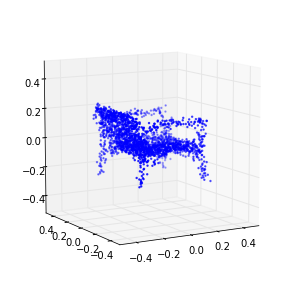

281 (-0.16933604120104401, 0.13033527370404313)
282 (-0.16970882128786158, 0.13013524824270495)
283 (-0.16888207428985172, 0.15229224799959748)
284 (-0.17279665276960091, 0.12487701768124546)
285 (-0.16580989322176687, 0.14154954999685287)
286 (-0.17032300200727252, 0.13364941392231872)
287 (-0.17497635389919633, 0.13873900086791427)
288 (-0.16849255650131792, 0.14992783301406437)
289 (-0.16586746584486078, 0.1326432407454208)
290 (-0.17024941836242322, 0.13576105899280971)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-290 is not in all_model_checkpoint_paths. Manually adding it.


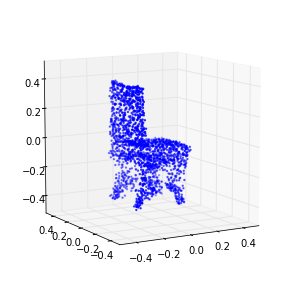

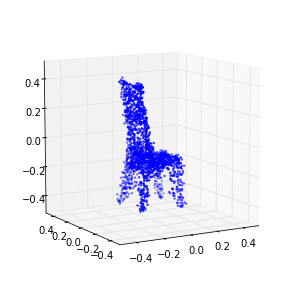

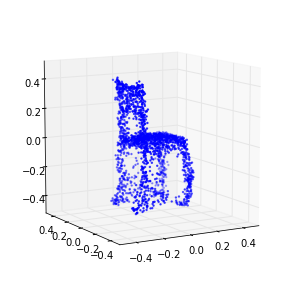

291 (-0.16541688696101861, 0.1197657688624329)
292 (-0.16867496542356633, 0.14695475705795819)
293 (-0.17115784419907465, 0.13166576044427025)
294 (-0.17016440999728663, 0.1343586479348165)
295 (-0.16934111835779966, 0.11299637594708691)
296 (-0.17022832963201734, 0.13544546026322576)
297 (-0.16531394303396896, 0.10411691941596844)
298 (-0.16336260029563196, 0.14343305732365008)
299 (-0.16941490002252438, 0.11589794426604554)
300 (-0.17148575821408518, 0.11223550058073467)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-300 is not in all_model_checkpoint_paths. Manually adding it.


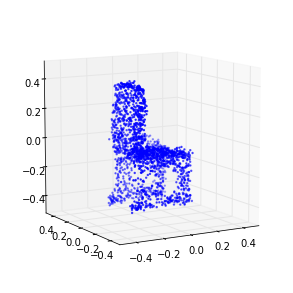

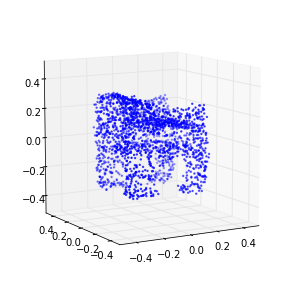

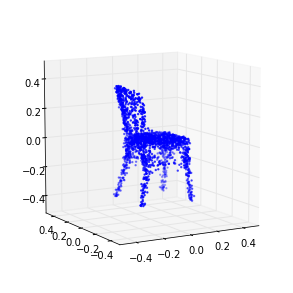

301 (-0.16521728171242608, 0.10496368107420427)
302 (-0.16864022193131623, 0.10049925979088854)
303 (-0.17220093635497269, 0.1078057839638657)
304 (-0.16530265460411708, 0.13774044452993958)
305 (-0.16889471290288149, 0.10458041051471675)
306 (-0.1663553523796576, 0.11794839606240944)
307 (-0.1670117602856071, 0.10796720700131522)
308 (-0.16840244239127194, 0.12480519049697453)
309 (-0.16658775055849995, 0.12482037298657277)
310 (-0.17053804789428359, 0.10650908477880337)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-310 is not in all_model_checkpoint_paths. Manually adding it.


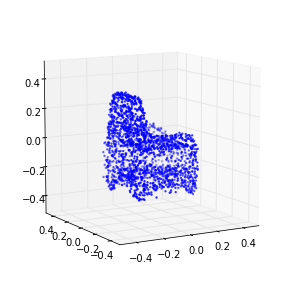

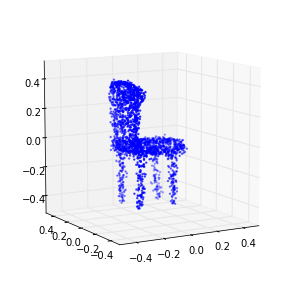

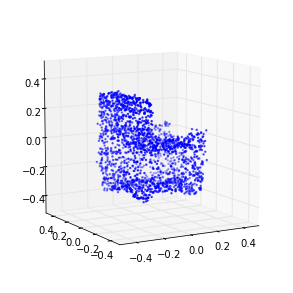

311 (-0.16929360799215459, 0.12141857654960067)
312 (-0.16637810981935924, 0.10326447696597488)
313 (-0.16465674589077631, 0.10638112091907749)
314 (-0.16526879535781014, 0.1124657667759392)
315 (-0.1706239331099722, 0.10663943165154369)
316 (-0.16742623233132892, 0.1211611351205243)
317 (-0.16464733078523919, 0.12042609243481248)
318 (-0.16771844614435125, 0.11946995445975551)
319 (-0.16759831254129057, 0.12826538513656016)
320 (-0.165192292465104, 0.097512490909408639)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-320 is not in all_model_checkpoint_paths. Manually adding it.


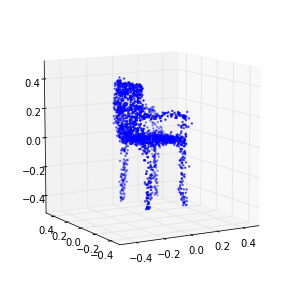

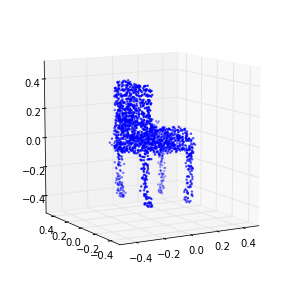

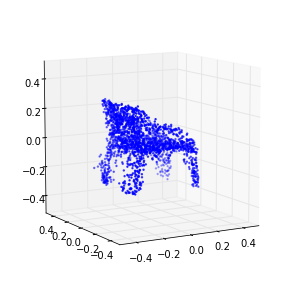

321 (-0.16589148861390574, 0.10159445857560193)
322 (-0.16730194527793812, 0.10488765493587211)
323 (-0.17010829636344202, 0.080776007983971526)
324 (-0.1698973235156801, 0.11273969654683713)
325 (-0.16739366771998229, 0.098442553094139809)
326 (-0.16693423395907436, 0.11320027543438806)
327 (-0.16941512999711214, 0.10462519719644829)
328 (-0.16598666674560972, 0.10745684223042594)
329 (-0.16531257971569344, 0.086000772675982232)
330 (-0.16804510906890588, 0.10378999925322002)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.


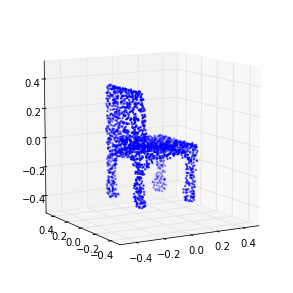

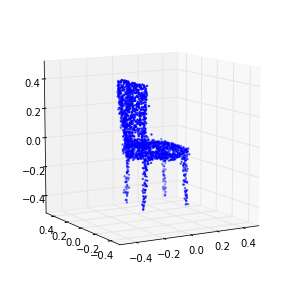

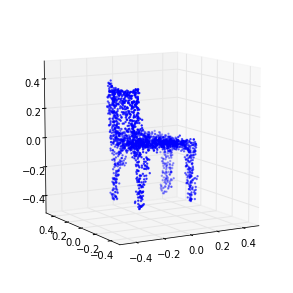

331 (-0.16730583740605248, 0.070990173973970949)
332 (-0.165632505107809, 0.093941831616339858)
333 (-0.16752385221145771, 0.091176061925512766)
334 (-0.1678796065074426, 0.074042413383722305)
335 (-0.16625931682410064, 0.091293357312679291)
336 (-0.16896545048113223, 0.086447704790367022)
337 (-0.16582426668869124, 0.073804086453660767)
338 (-0.16352706546032869, 0.084358679199660266)
339 (-0.16793932666381201, 0.081675284645623625)
340 (-0.16078529788388146, 0.08900119088314197)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.


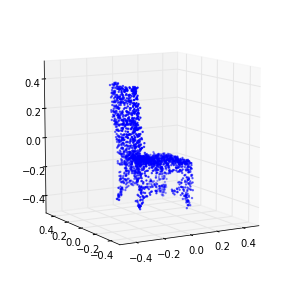

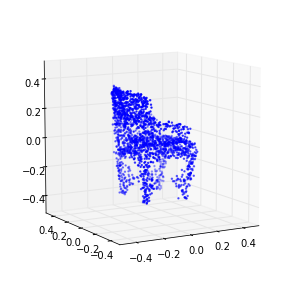

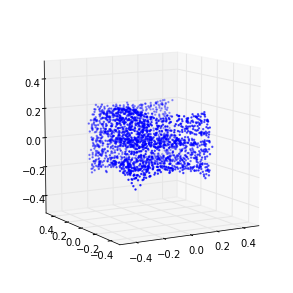

341 (-0.17096452867543255, 0.082261221138415511)
342 (-0.16795942788874663, 0.06872712203335983)
343 (-0.16640634023480946, 0.077196256947462211)
344 (-0.16790270413513536, 0.095465123929359297)
345 (-0.16705927051327846, 0.071774774541457489)
346 (-0.16673558238479827, 0.091166220743347098)
347 (-0.1659974745578236, 0.081514969295649622)
348 (-0.1637268633754165, 0.081749251181328739)
349 (-0.16427943276034462, 0.081501875521132236)
350 (-0.16847916979480673, 0.064849195243031885)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


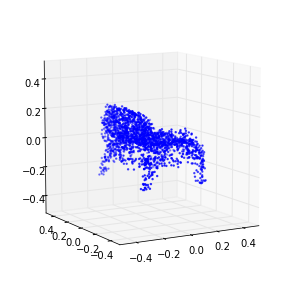

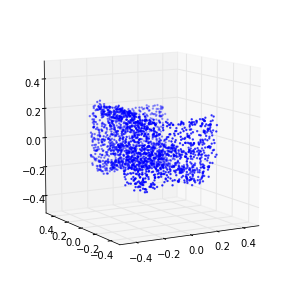

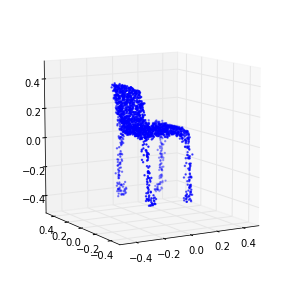

351 (-0.16943629406116628, 0.0638823288458365)
352 (-0.16620858846991152, 0.06522384065168875)
353 (-0.16545575973060395, 0.051895107711768813)
354 (-0.16511358798102097, 0.070276445260754342)
355 (-0.16073063965196963, 0.075682659943898514)
356 (-0.16613258473851061, 0.072195911848986591)
357 (-0.16503885415969072, 0.076868279802578474)
358 (-0.1685335675875346, 0.068073775895215849)
359 (-0.16542255812221104, 0.072411602569950953)
360 (-0.16662609571660006, 0.04862746110841356)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.


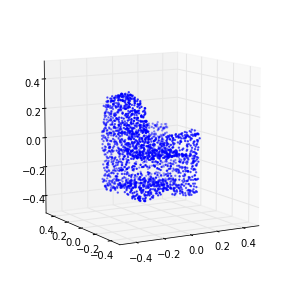

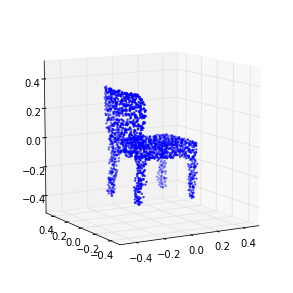

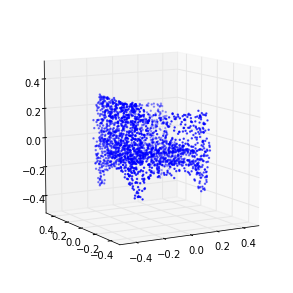

361 (-0.16562649982946889, 0.060333361711215089)
362 (-0.16714070213061791, 0.06186605403544726)
363 (-0.16881977915763854, 0.047195390711917924)
364 (-0.16582130723529392, 0.065209743187383373)
365 (-0.16714412845947124, 0.066775175846285284)
366 (-0.16713375863101748, 0.058133830695792484)
367 (-0.1645815341009034, 0.064584023940066501)
368 (-0.1653871386691376, 0.039665904620455369)
369 (-0.1644156972291293, 0.058129181430019716)
370 (-0.16776126192675697, 0.060014539053318675)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-370 is not in all_model_checkpoint_paths. Manually adding it.


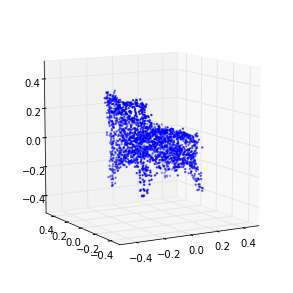

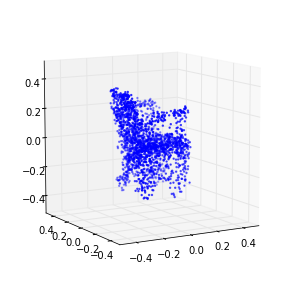

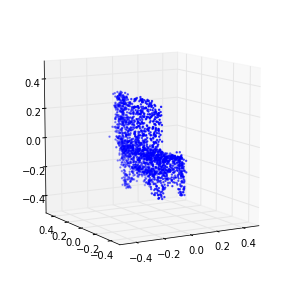

371 (-0.16587718264372261, 0.044791559412799498)
372 (-0.1618997167106028, 0.039728369218883688)
373 (-0.16835604183099889, 0.075122827733004535)
374 (-0.16502841219857886, 0.064272425516887943)
375 (-0.16403152230713103, 0.037602594846652612)
376 (-0.1674896110539083, 0.035294531189181189)
377 (-0.16380536214069083, 0.051498751225018943)
378 (-0.16549398849407831, 0.036070429685491102)
379 (-0.16232068064036193, 0.032260861937646511)
380 (-0.16516857318304204, 0.042519473281033615)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-380 is not in all_model_checkpoint_paths. Manually adding it.


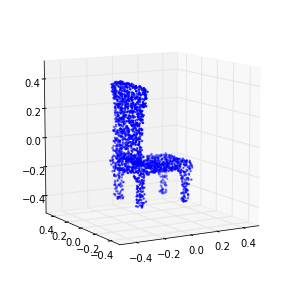

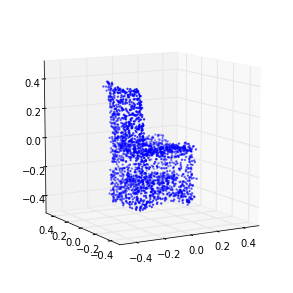

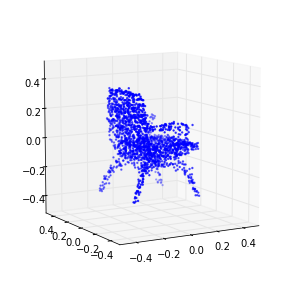

381 (-0.16327278862396877, 0.061294140501154795)
382 (-0.15776508825796623, 0.042395428469818502)
383 (-0.16549556293973217, 0.049712302439190725)
384 (-0.16522372875500607, 0.045661891569141987)
385 (-0.16571961161163118, 0.031748357849816479)
386 (-0.16666850215858883, 0.049812452850380433)
387 (-0.1664100718167093, 0.028643991763669031)
388 (-0.17094625841688227, 0.040861343551013202)
389 (-0.16113796736355182, 0.02898378092450676)
390 (-0.16559303640215486, 0.033760947054596965)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-390 is not in all_model_checkpoint_paths. Manually adding it.


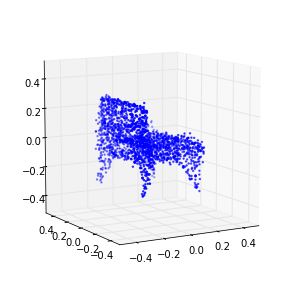

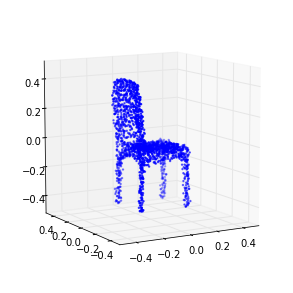

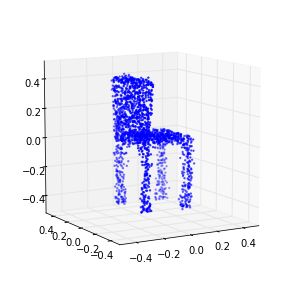

391 (-0.16454200325188814, 0.030041433439624531)
392 (-0.16032908608516058, 0.027585178268728434)
393 (-0.1622403629952007, 0.019208221868784341)
394 (-0.16591938667827183, 0.011344562646829419)
395 (-0.16549593866975218, 0.037347817724501645)
396 (-0.16200119290086959, 0.025055098088665143)
397 (-0.16211802269573564, 0.024293248291575798)
398 (-0.1605315250379068, 0.027394362009578833)
399 (-0.16719816906584634, 0.0065675795561185588)
400 (-0.16815061806528656, 0.048270003275117941)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-400 is not in all_model_checkpoint_paths. Manually adding it.


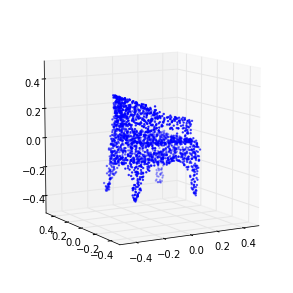

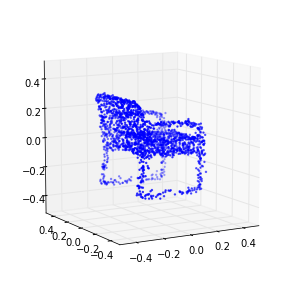

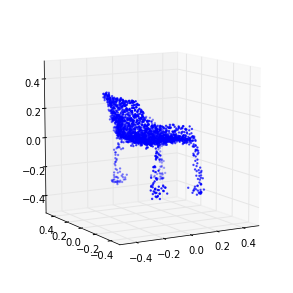

401 (-0.16395832068390317, 0.022083790679634722)
402 (-0.16516108962672729, 0.03516083716897777)
403 (-0.16419680273091353, 0.035863762221264618)
404 (-0.16238341353557728, 0.034601759717420293)
405 (-0.16668160513595298, 0.021583812233681481)
406 (-0.16305834485424889, 0.038962135919266276)
407 (-0.16371077839975004, 0.0029495466345300279)
408 (-0.16609038578139412, 0.027918540389725455)
409 (-0.16448103321923149, 0.014605033366630474)
410 (-0.16437674131658342, 0.027754249154693551)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-410 is not in all_model_checkpoint_paths. Manually adding it.


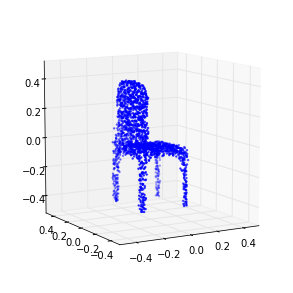

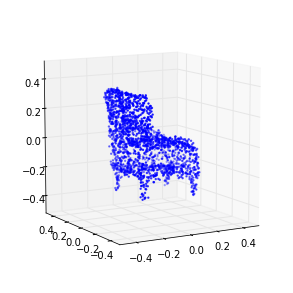

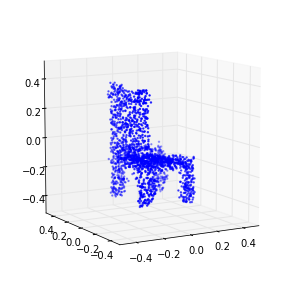

411 (-0.16461543871296777, 0.022576563612178521)
412 (-0.16266968680752647, 0.011567058628080067)
413 (-0.16491898535578339, 0.019363132771104574)
414 (-0.1618585753220099, 0.020849883694339683)
415 (-0.16582447444951093, 0.015584476318003403)
416 (-0.16419121733418218, 0.02954993152094108)
417 (-0.16099721910776915, 0.030832465962265378)
418 (-0.16392495775664295, 0.015621534665115178)
419 (-0.16023567892886975, 0.037585446352346077)
420 (-0.16403531939895064, 0.027026275948931772)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-420 is not in all_model_checkpoint_paths. Manually adding it.


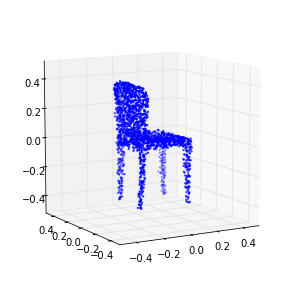

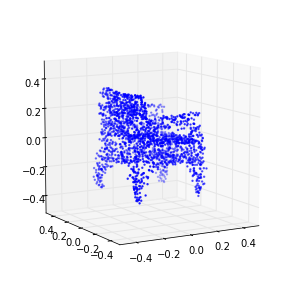

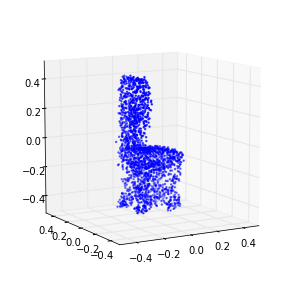

421 (-0.1623716594444381, 0.026016083218295266)
422 (-0.16242602357157954, 0.012066939552487046)
423 (-0.16507769260141586, 0.018324813874507392)
424 (-0.16432996326022678, 0.01841427359936966)
425 (-0.16470340887705484, 0.015463098193760271)
426 (-0.16665329637902754, 0.0045236020038525266)
427 (-0.15879817759549175, 0.014073276116202274)
428 (-0.16001527463948284, 0.032478233005989482)
429 (-0.16410905923004504, 0.019379449904792838)
430 (-0.16226735098494424, 0.031097612542065757)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.


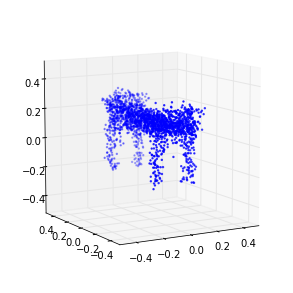

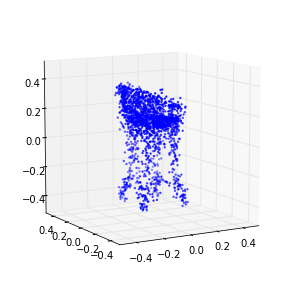

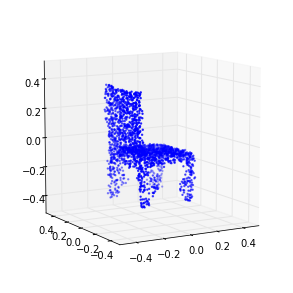

431 (-0.1674617385422742, 0.022608753811154101)
432 (-0.15856621756597802, 0.04170849693387195)
433 (-0.1673425879743364, 0.027241319314473204)
434 (-0.16255196167363062, 0.035872681238860997)
435 (-0.16484408064021006, 0.015196440275758505)
436 (-0.16011459595627256, 0.0059832163948427752)
437 (-0.16364100144969093, 0.019203272320468118)
438 (-0.16165414447033846, 0.010760600109481148)
439 (-0.1653289654188686, 0.021367170020110078)
440 (-0.16485852626738726, 0.0039787426832373499)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.


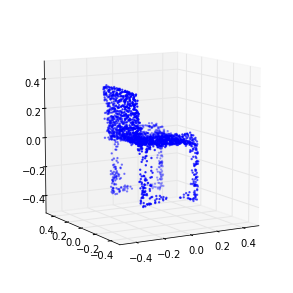

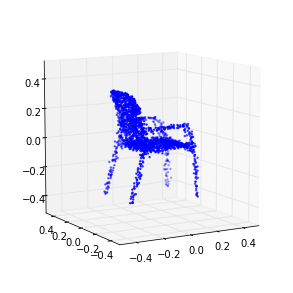

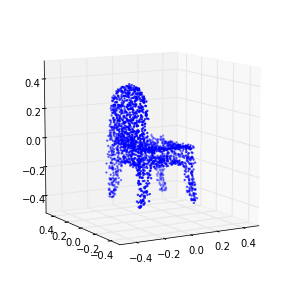

441 (-0.16264485363607054, 0.020643852064730944)
442 (-0.16311713622676002, 0.01626875724091574)
443 (-0.16235602702255603, 0.0099661481842674583)
444 (-0.16092019588858994, 0.012400742361529006)
445 (-0.16507041310822523, -0.014272822757010107)
446 (-0.16172449213487131, 0.024361489840817672)
447 (-0.16248278198418795, 0.021358830957776971)
448 (-0.16248195745326854, 0.0066591485713919001)
449 (-0.16302714521686237, 0.0020389015855336629)
450 (-0.16632339937819374, 0.022798013597450876)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


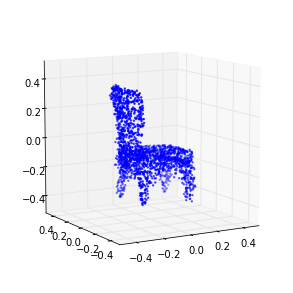

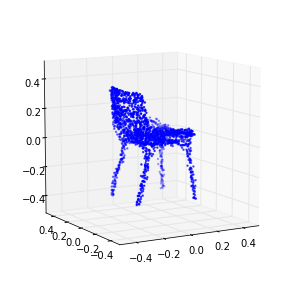

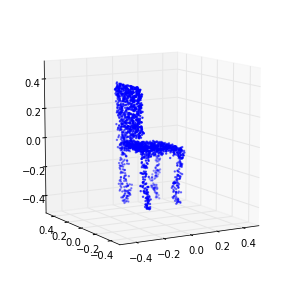

451 (-0.15981769007113245, 0.0044303583326163118)
452 (-0.16399784336487452, 0.015071909581483514)
453 (-0.16443537479197537, 0.0060643064272072576)
454 (-0.16592380117487024, 0.0049584415499810816)
455 (-0.1624322715456839, 0.010445154729057793)
456 (-0.1618434644959591, -0.0028468639572599421)
457 (-0.16617271640786418, 0.011053725947729416)
458 (-0.16438697311613296, 0.006736941670102102)
459 (-0.16180027276277542, 0.0077312913619809681)
460 (-0.16111530380116568, 0.015332374135377231)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-460 is not in all_model_checkpoint_paths. Manually adding it.


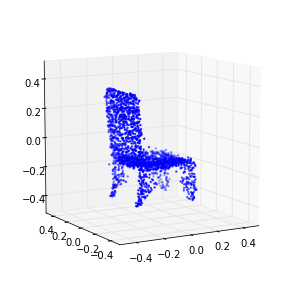

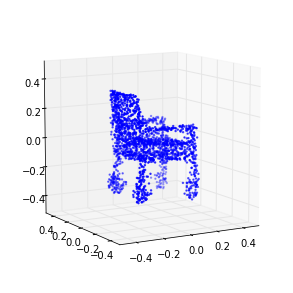

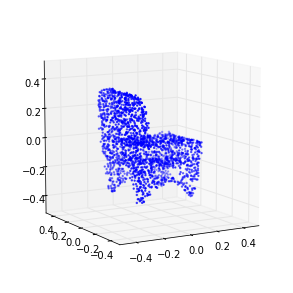

461 (-0.16267943509199001, -0.0093459725655891269)
462 (-0.16432604806290732, 0.022027664386701805)
463 (-0.16075759645965365, 0.014122448292457394)
464 (-0.16422385082200722, 0.017889928038197535)
465 (-0.16237323637361881, 0.0045248661707672812)
466 (-0.16080914247367117, 0.0010480750438377814)
467 (-0.16197220004267163, 0.013985349193077397)
468 (-0.16494003048649541, 0.023611941029904066)
469 (-0.15996771410659508, 0.01146739015907601)
470 (-0.15897514215774006, 0.015889594555590993)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_10_emd_chair_2048_best_epoch/models.ckpt-470 is not in all_model_checkpoint_paths. Manually adding it.


In [ ]:
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
save_dir = create_dir(save_dir)

buf_size = 1 # flush each line
if do_training:    
    train_stats = []
    log_file = open(osp.join(train_dir, 'train_stats.txt'), 'a', buf_size)
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss                
        log_file.write('%04d\t%.9f\t%.9f\t%.4f\n' % (epoch, loss[0], loss[1], duration / 60.0))        

        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot(in_u_sphere=True)
                        
        train_stats.append((epoch,) + loss)
    log_file.close()

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('NB_WGAN_GP training. (%s, %s, %s-bneck)' %(class_name, ae_loss, ae.bottleneck_size))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')
    
    plt.savefig(osp.join(train_dir, 'training_curve.png'))